In [31]:
%pip install awkward pyarrow matplotlib numpy

Note: you may need to restart the kernel to use updated packages.


In [32]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import awkward as ak

### Load the data from file

In [33]:
f = ak.from_parquet('particles.parquet')
pt, eta, phi, met_ref = f.pt, f.eta, f.phi, f.met

### Reference MET implementation

This implementation is as simple as can be:
- run over all events at once
- split the particle momentum into x & y components
- sum the px and py for the particles in each event
- compute the vector magnitude from the MET x & y components

In [34]:
def compute_met(pt : ak.Array,
                phi : ak.Array):
    # compute the x and y components of each particle's pT
    px = pt * np.cos(phi)
    py = pt * np.sin(phi)
    # sum over the particles to calculate the MET vector (px, py)
    met_x = np.sum(px, axis=1)
    met_y = np.sum(py, axis=1)
    # compute the magnitude of the MET vector
    met = np.sqrt(met_x**2 + met_y**2)
    return met

In [35]:
# compute the MET reference
met_ref = compute_met(pt, phi)

In [47]:
# load the MET computation from HLS testbench
# a dummy file of zeros is provided, run this again with your real results!
met_hls = np.genfromtxt('met_hls.csv')
met_hls_float = np.genfromtxt('met_hls_float.csv')

### Plot MET distribution

You can overlay your results onto this as another plot.

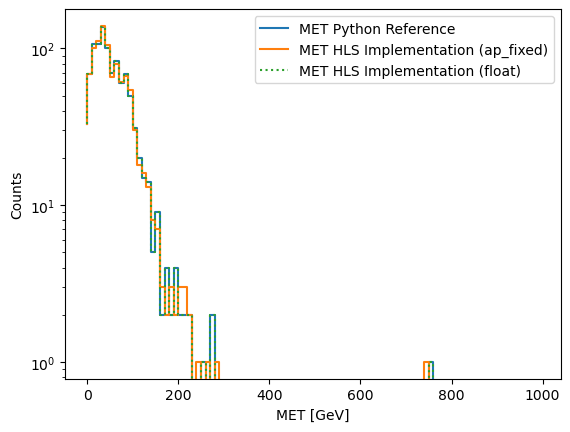

In [58]:
bins_spectrum = np.linspace(0, 1000, 101)
hist_ref, _ = np.histogram(met_ref, bins=bins_spectrum)
hist_hls, _ = np.histogram(met_hls, bins=bins_spectrum)
hist_hls_float, _ = np.histogram(met_hls_float, bins=bins_spectrum)
plt.step(bins_spectrum[:-1], hist_ref, label='MET Python Reference')
plt.step(bins_spectrum[:-1], hist_hls, label='MET HLS Implementation (ap_fixed)')
plt.step(bins_spectrum[:-1], hist_hls_float, ':', label='MET HLS Implementation (float)')
plt.semilogy()
plt.legend()
plt.xlabel('MET [GeV]')
plt.ylabel('Counts')
plt.savefig('met_distribution.png')
plt.savefig('met_distribution.pdf')

### Plot MET Residual

Plot the residual between the MET reference and yours. A dummy file is provided where the MET is always 0, yours should look much better!

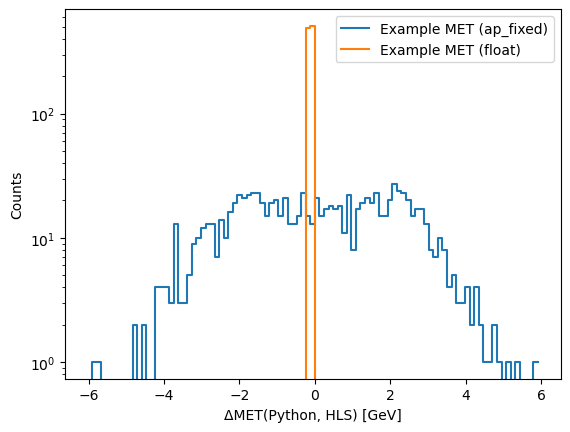

In [51]:
met_residual = met_ref - met_hls
met_residual_float = met_ref - met_hls_float
max_residual = np.max(np.abs(met_residual))
bins_residual = np.linspace(-max_residual, max_residual, 101)
hist_residual, _ = np.histogram(met_residual, bins_residual)
hist_residual_float, _ = np.histogram(met_residual_float, bins_residual)

plt.step(bins_residual[:-1], hist_residual, label='Example MET (ap_fixed)')
plt.step(bins_residual[:-1], hist_residual_float, label='Example MET (float)')

plt.semilogy()
plt.legend()
plt.xlabel('ΔMET(Python, HLS) [GeV]')
plt.ylabel('Counts')
plt.savefig('met_residual.png')
plt.savefig('met_residual.pdf')

## Test

You can use this tolerance test to check whether your implementation is viable. The targets are:
- absolute MET never more than 10 GeV different than the reference
- relative MET never more than 2% different than the reference

In [52]:
try:
    np.testing.assert_allclose(met_hls, met_ref, rtol=0.02, atol=10)
    print("All Close")
except AssertionError as AE:
    print(AE)

All Close


With

```c++
typedef float T_pt;
typedef float T_phi;
typedef float T_pxy;
typedef float T_MET;
```

| Modules & Loops                        | Issue Type | Slack | Latency (cycles) | Latency (ns) | Iteration Latency | Interval | Trip Count | Pipelined | BRAM | DSP      | FF        | LUT       | URAM |
|----------------------------------------|------------|--------|------------------|---------------|-------------------|----------|-------------|-----------|------|----------|-----------|-----------|------|
| + compute_met                          | -          | 0.34   | 458797           | 4.588e+06     | -                 | 458798   | -           | no        | -    | 21 (8%)  | 3535 (2%) | 3816 (6%) | -    |
| + compute_met_Pipeline_ParticleLoop    | -          | 0.34   | 458769           | 4.588e+06     | -                 | 458769   | -           | no        | -    | 13 (5%)  | 2753 (2%) | 3094 (4%) | -    |
| o ParticleLoop                         | II         | 7.30   | 458767           | 4.588e+06     | 30                | 7        | 65535       | yes       | -    | -        | -         | -         | -    |
| + sin_or_cos_float_s                   | II         | 0.34   | 16               | 160.000       | -                 | 1        | -           | yes       | -    | 13 (5%)  | 2415 (1%) | 2830 (4%) | -    |

With:
```c++
typedef ap_fixed<12,10> T_pt;
typedef ap_fixed<12,4> T_phi;
typedef ap_fixed<16,12> T_pxy;
typedef ap_fixed<13,11> T_MET;
```

| Modules & Loops                          | Issue Type | Slack | Latency (cycles) | Latency (ns) | Iteration Latency | Interval | Trip Count | Pipelined | BRAM     | DSP     | FF         | LUT        | URAM |
|------------------------------------------|-------------|--------|------------------|---------------|--------------------|----------|-------------|-----------|----------|---------|-------------|------------|------|
| + compute_met                             | -           | 0.15   | 1835002          | 1.835e+07     | -                  | 1835003  | -           | no        | 4 (1%)   | 6 (2%)  | 2410 (1%)   | 4856 (7%)  | -    |
| + sqrt_fixed_33_25_s                      | II          | 0.15   | 15               | 150.000       | -                  | 1        | -           | yes       | -        | -       | 2028 (1%)   | 4045 (6%)  | -    |
| o ParticleLoop                            | -           | 7.30   | 1834980          | 1.835e+07     | 28                 | -        | 65535       | no        | -        | -       | -           | -          | -    |
| + compute_met_Pipeline_VITIS_LOOP_87_1    | -           | 0.97   | 18               | 180.000       | -                  | 18       | -           | no        | 4 (1%)   | -       | 102 (~0%)   | 337 (~0%)  | -    |
| o VITIS_LOOP_87_1                         | -           | 7.30   | 16               | 160.000       | 4                  | 1        | 14          | yes       | -        | -       | -           | -          | -    |


### More tools

This exercise is all about choosing the right precision for your variables. You want to minimise the resources and latency without compromising the MET precision. Below are some visualizations that will help you to choose the right precision.

(0.0, 690.8000000000001)

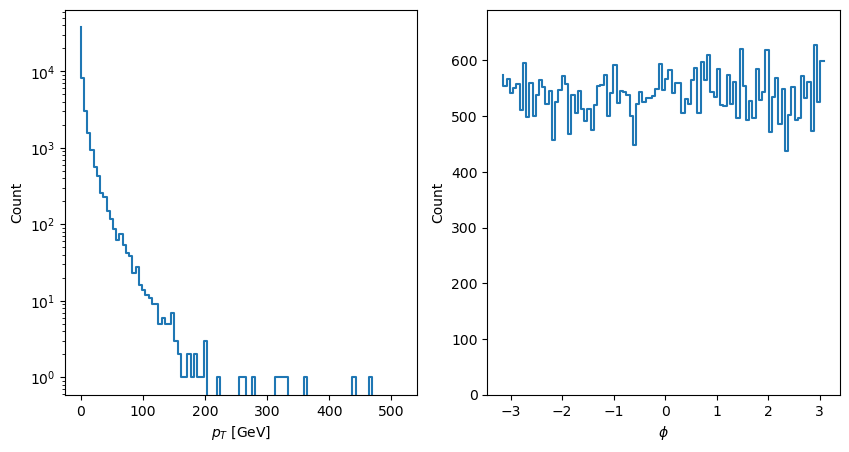

In [40]:
f, axs = plt.subplots(1,2, figsize=(10,5))
bins_pt = np.linspace(0, ak.max(pt)*1.1, 101)
hist_pt, _ = np.histogram(ak.ravel(pt), bins=bins_pt)
axs[0].step(bins_pt[:-1], hist_pt)
axs[0].semilogy()
axs[0].set_xlabel("$p_T$ [GeV]")
axs[0].set_ylabel("Count")

bins_phi = np.linspace(-np.pi, np.pi, 101)
hist_phi, _ = np.histogram(ak.ravel(phi), bins=bins_phi)
axs[1].step(bins_phi[:-1], hist_phi)
#axs[0].semilogy()
axs[1].set_xlabel("$\phi$")
axs[1].set_ylabel("Count")
axs[1].set_ylim((0, np.max(hist_phi)*1.1))

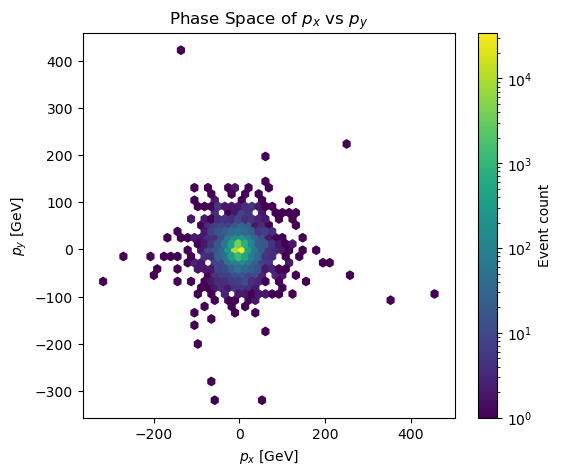

In [41]:
px = pt * np.cos(phi)
py = pt * np.sin(phi)

plt.figure(figsize=(6, 5))
plt.hexbin(ak.ravel(px), ak.ravel(py), gridsize=50, cmap='viridis', norm=matplotlib.colors.LogNorm())
plt.xlabel("$p_x$ [GeV]")
plt.ylabel("$p_y$ [GeV]")
plt.title("Phase Space of $p_x$ vs $p_y$")
plt.colorbar(label="Event count")

In [42]:
# Try out quantizing different parts of the computation in Python before HLS
# You can use this to help think about the fractional part
# e.g. here we quantize the pt and phi
# consider that the full computation also include quantizing the computations in the compute_met function
pt_q = ak.round(pt / 2**-1) * 2**-1
phi_q = ak.round(phi / 2**-4) * 2**-4

met_q = compute_met(pt_q, phi_q)

print(f"Quantized MET: {met_q[0]:.2f} GeV")
print(f"Reference MET: {met_ref[0]:.2f} GeV")

Quantized MET: 69.24 GeV
Reference MET: 71.14 GeV
